In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pyharm
from scipy.optimize import curve_fit

ModuleNotFoundError: No module named 'pyharm'

In [ ]:
home_dir = "csv/"
#fnames = os.listdir(home_dir)

# 5 slices from the theta grid [0, 128)
theta_list = [0, 31, 63, 95, 127]
var_list = ["u1", "u3"]
spin_list = ["+0.94", "+0.5", "0", "-0.5", "-0.94"]

# dump is used to get r values only
dump = pyharm.load_dump("Sa0_0000.h5")
r = dump["r1d"]

# color scale for the theta values
theta_color = {
    theta_list[0]: 'blue',
    theta_list[1]: 'orange',
    theta_list[2]: 'green',
    theta_list[3]: 'red',
    theta_list[4]: 'purple'
    }

print(theta_color)

{0: 'blue', 31: 'orange', 63: 'green', 95: 'red', 127: 'purple'}


In [28]:
def plot(ax, spin, var='u^phi', keplerian=True, isco=False, yscale=None, xscale=None, divide_ut=False,fitrange=None, 
         f=None, th_list=theta_list, title=None, loc=1, divide_isco=False, ylabel=None, find_nR=False):
    a = float(spin)

    # get temporal + azimuthal averaged values of the angular velocity
    mean = np.loadtxt(home_dir + f"avg_{var}_{spin}.csv", delimiter=",") 

    # get boyer linguist value
    if divide_ut:
        ut = np.loadtxt(home_dir + f"avg_u^t_{spin}.csv", delimiter=",") 
        mean /= ut
    
    # Apply arbitrary function
    if f is not None:
        mean = f(mean)
    """
    sd = np.loadtxt(home_dir+"sd"+var+spin+".csv", delimiter=",")

    for th in range(len(theta_list)-2):
        ax.plot(r, mean[th], label="th="+str(theta_list[th]))
        plt.fill_between(r, mean[th]-sd[th], mean[th]+sd[th], label=str(theta_list[th])+"+-1sd", alpha=0.3)
    """

    # Plot r=isco
    a = float(spin)
    z1 = 1. + (1. - a * a) ** (1. / 3.) * ((1. + a)**( 1. / 3.) + (1. - a)**( 1. / 3.))
    z2 = np.sqrt(3. * a * a + z1 * z1)
    if a != 0:
        r_isco = 3. + z2 - (np.sqrt((3. - z1) * (3. + z1 + 2. * z2))*np.abs(a)/a)
    else:
        r_isco = 3. + z2 - (np.sqrt((3. - z1) * (3. + z1 + 2. * z2))*np.abs(a))
    if divide_isco:
        r_isco /= r_isco
    if isco and not divide_isco:    
        ax.axvline(x=r_isco, linestyle='--', color='black')
    
    # Divide r by r_isco    
    if divide_isco:
        r = dump['r1d'] / r_isco
    else:
        r = dump['r1d']
        
    # Plot var of different theta values
    for th in th_list:
        i = theta_list.index(th) # index in theta_list
        rad = ((th + 1) / 128).as_integer_ratio() # in fraction
        # formatting fraction
        if rad[0] == 1 and rad[1] == 1:
            label = r'$\theta=\pi$'
        elif rad[0] == 1:
            label = r'$\theta=$' + r'$\pi$/' + f'{rad[1]}'
        elif rad[1] == 1:
            label = r'$\theta=$' + f'{rad[0]}' + r'$\pi$'
        else:
            label = r'$\theta=$' + f'{rad[0]}' + r'$\pi$/' + f'{rad[1]}'

        if divide_isco:
            ax.plot(r/r_isco, mean[i], theta_color[th],label=label)
        else:
            ax.plot(r, mean[i], theta_color[th],label=label)
    
    # fit straight line, originally 50:200
    if fitrange is not None and find_nR:    
        def fit_func(r, nu, nR):
            return -nu * r ** nR
        params = curve_fit(fit_func, dump['r1d'][fitrange[0]:fitrange[1]], mean[2][fitrange[0]:fitrange[1]])
        

        [nu, nR] = params[0]
        ax.plot(r, fit_func(r, nu, nR), linestyle="--", label=r"$n_R$=" + str(-round(nR, 4)))
    else:
        trend = np.polyfit(np.log(r)[fitrange[0]:fitrange[1]], np.log(mean[2])[fitrange[0]:fitrange[1]], 1)
        eq = np.poly1d(trend)
        ax.plot(r, np.exp(eq[0]) * (r ** eq[1]), linestyle="--", label=r"$q_\mathrm{shear}$="+f"{-round(trend[0], 4)}")
        
    # Plot keplerian
    if keplerian:
        ax.plot(r, 1/(r ** (1.5) + a), linestyle="--", label="Keplerian " + r"$r^{-3/2}$")

    # Formatting
    if spin_list.index(spin) == 0:      # ylabel
        if ylabel is not None:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel(f"{var}")
    if divide_isco:                     # xlabel
        ax.set_xlabel(r"$r / r_\mathrm{ISCO}$")
    else:
        ax.set_xlabel(pyharm.pretty('r'))
    ax.legend(frameon=False, loc=loc)   # legend
    if title is None:                   # title
        ax.set_title(f"{var}" + r", $a_\mathrm{spin}=$" + str(a))
    else:
        ax.set_title(title + r", $a_\mathrm{spin}=$" + str(a))
    
    # Set scale
    if xscale is not None:
        ax.set_xscale(xscale)
    if yscale is not None:
        ax.set_yscale(yscale)


# $q_\mathrm{shear}$
$\Omega=u^{\phi}/u^{t}$

/var/folders/f5/93qk9czs7835g6z9_k6k6wvc0000gn/T/ipykernel_60098/3163770953.py:10: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[i].set_xlim(0, 100)


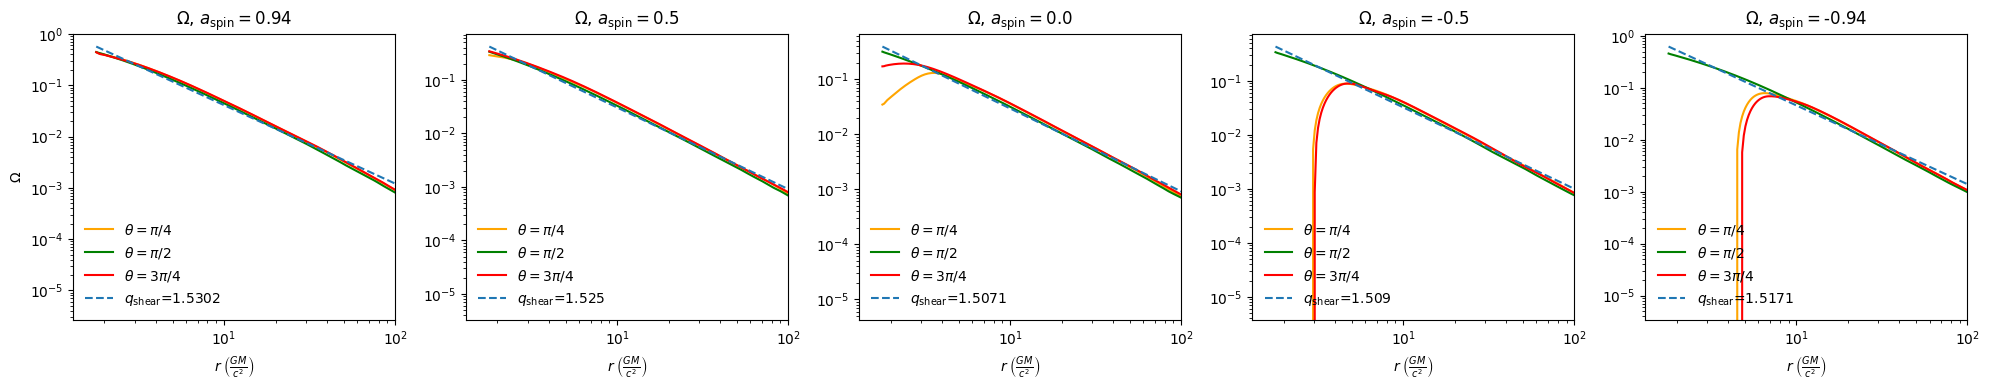

In [29]:
# Plotting omega = u^phi / u^t
fig, axes = plt.subplots(1, len(spin_list), figsize=(20, 4))
"""
fitrange: determine where to fit in the straightline
r should be in range of [0, 288) as the GRMHD simulation has 288 grids in r direction
"""
for i in range(len(spin_list)):
    plot(axes[i], spin_list[i], var='Omega', xscale='log', yscale='log', fitrange=[0, 150], title=r'$\Omega$', ylabel=r'$\Omega$', loc=3, th_list=[31, 63, 95], keplerian=False) # r from 0 to 50 GM/c^2
    axes[i].set_xlabel(pyharm.pretty('r'))
    axes[i].set_xlim(0, 100)
plt.tight_layout()
#plt.savefig(f'{var}.png')
plt.show()

# $n_R$

/var/folders/f5/93qk9czs7835g6z9_k6k6wvc0000gn/T/ipykernel_60098/4224718651.py:21: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[a].set_xlim(0, 100)


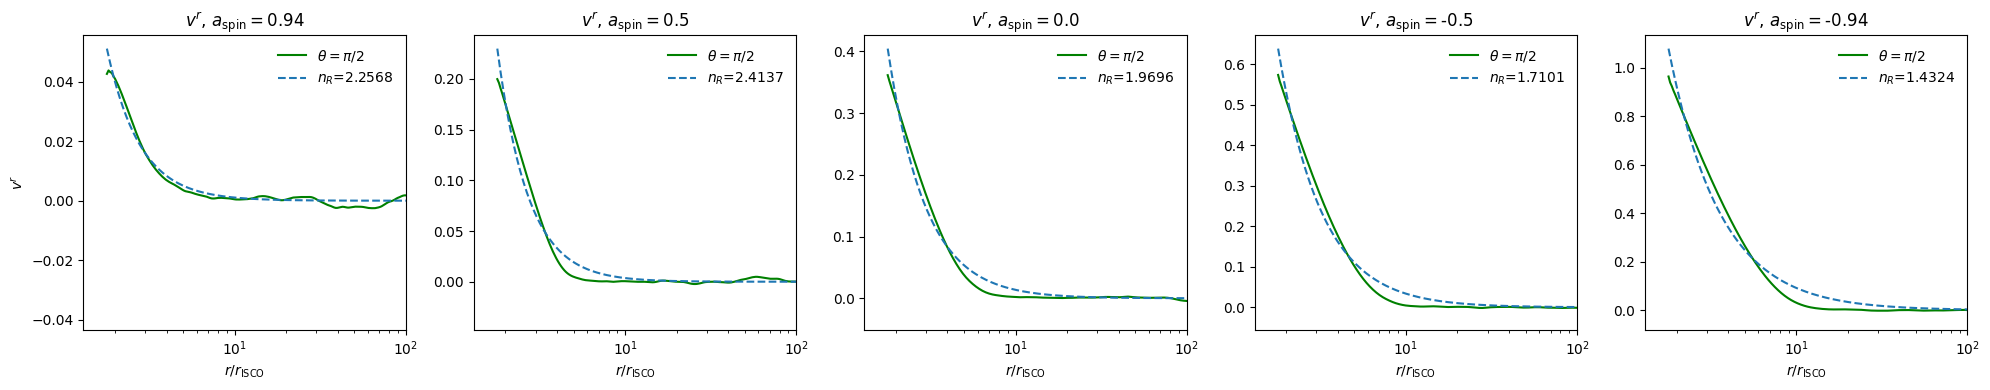

In [30]:
# Plotting v^r = u^r / u^t
fig, axes = plt.subplots(1, len(spin_list), figsize=(20, 4))
"""
fitrange: determine where to fit in the straightline
r should be in range of [0, 288) as the GRMHD simulation has 288 grids in r direction
"""


def neg(x):
    return -x

for a, spin in enumerate(spin_list):
    # changing the fitrange according to aspin to only fit the range outside of r_isco
    if float(spin) < 0:
        plot(axes[a], spin_list[a], var='u^r',fitrange=[0, 288], keplerian=False, xscale='log', isco=True, f=neg, th_list=[63],
         divide_ut=True, title=r'$v^r$', divide_isco=True, ylabel=r'$v^r$', find_nR=True) 
    else:
        plot(axes[a], spin_list[a], var='u^r',fitrange=[0, 288], keplerian=False, xscale='log', isco=True, f=neg, th_list=[63],
         divide_ut=True, title=r'$v^r$', divide_isco=True, ylabel=r'$v^r$', find_nR=True) 
    #axes[i].set_ylim(0, 1)
    axes[a].set_xlim(0, 100)
plt.tight_layout()
plt.show()

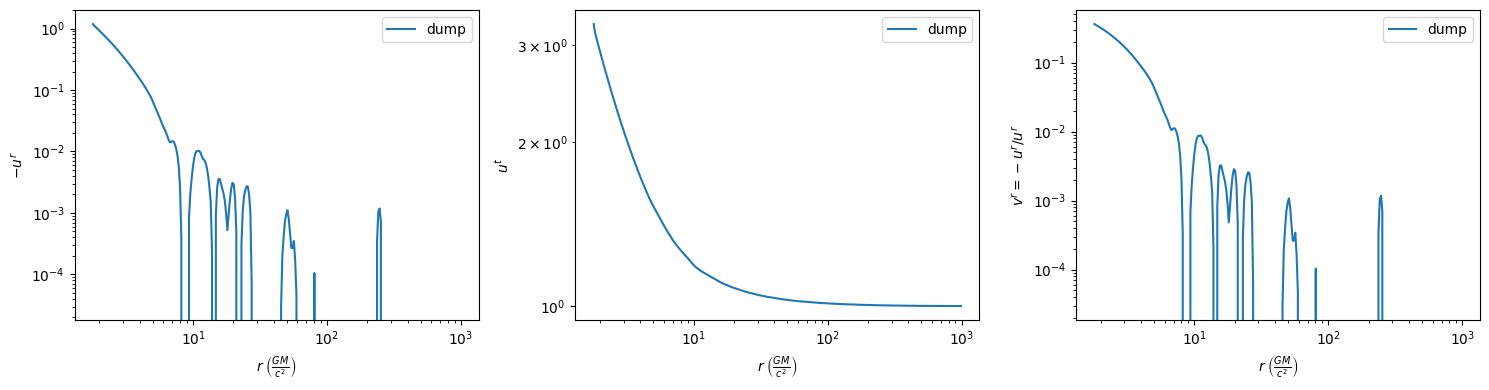

In [7]:
# Plotting quantities from single snapshot
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ur = pyharm.shell_avg(dump, 'u^r', j_slice=[63, 64])
ut = pyharm.shell_avg(dump, 'u^t', j_slice=[63, 64])
vr = ur / ut

ax[0].plot(r, -ur, label='dump')
ax[0].set_ylabel(pyharm.pretty('-u^r'))
ax[1].plot(r, ut, label='dump')
ax[1].set_ylabel(pyharm.pretty('u^t'))
ax[2].plot(r, -vr, label='dump')
ax[2].set_ylabel(r'$v^r=-u^r/u^r$')

for i in range(3):
    ax[i].set_xlabel(pyharm.pretty('r'))
    ax[i].set_yscale("log")
    ax[i].set_xscale('log')
    ax[i].legend()


plt.tight_layout()